# Week 7 Overview

Last week, you started learning to use NumPy to represent and work with lots of numbers efficiently. This week, you will learn about NumPy's more advanced features. First, you will learn about views, a powerful space sharing technique allowing certain reorganizations and transformations of arrays to be done instantly. These transformations will be common in linear algebra and, thus an integral part of building large models later in this program. Then, we will wrap up our coverage of NumPy with a few odds and ends to round out your knowledge; pointers to linear algebra routines for Module 1, useful but less common features of NumPy, and some warnings about potential performance traps. Next week, we will move on to pandas, a library for structured data that will combine the strengths of NumPy with more flexible analysis and manipulation.

### Learning Objectives
At the end of this week, you should be able to:
- Describe the behavior of NumPyviews and when they can be used
- Use standard views to reshape and transform arrays
- Check if a given NumPy array is a view or not
- Find and use NumPy functions for linear algebra and other operations as needed
- Explain the usage of less common NumPy array structures
- Identify slow array creation patterns and explain how to avoid them

## NumPy Views

We will now learn about NumPy views. NumPy views are a fast and powerful feature when they can be used. They allow a new array to be created that shares the data of an existing array, so they can be created in time dependent on the number of dimensions, not the number of elements in the array. For a 2-3 dimensional array with millions of elements, using a view can change many operations from slow copies to instant results.

To see how this works, when views can be used, and why they can be dangerous, we will start with a look into how NumPy arrays are organized internally. From there, we will investigate how a new view is created, and what limits the creation of new views. We will then cover the most common operations using views, starting with the special array indexing that you saw last week.

### Learning Objectives
- Describe the behavior of numpy views and when they can be used
- Use standard views to reshape and transform arrays
- Check if a given numpy array is a view or not

#### Think About It
Have you ever solved a problem that became trivial when you looked at it from a certain point of view?

### NumPy Array Layouts

To understand how NumPy views work, you will first need to understand how NumPy arrays work internally. Previously, we said that a NumPy array has many values packed closely together, but any particular value of interest can be found and accessed quickly. We will now look into the specifics of how this works.

#### Contiguous (NumPy)

An array is contiguous if:
1.  it occupies an unbroken block of memory, and
2.  array elements with higher indexes occupy higher addresses (that is, no stride is negative).

The first requirement specifies that there is a section of memory holding the array elements and nothing else. Basically, the array elements are as close to each other in memory as possible.

The second requirement restricts memory access patterns when reading through the array (strides will be defined shortly). Suppose that your code just read element x[i,j,k] and the next element to read will be one of x[i+1,j,k], x[i,j+1,j], or x[i,j,k+1]? Are all those choices reading higher (later) memory addresses? Which one is closest? One of them must be closest, or they'll be sharing memory and not actually different elements.

Consider the following code example with two nested for loops reading the same three dimensional array. These two for loops correspond to the two orders reading from the book. Which is more efficient?

In [1]:
import numpy as np
 
x = np.zeros((40, 50, 60))
 
# row order traversal
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        for k in range(x.shape[2]):
            x[i,j,k] # do something
 
# column order traversal
for k in range(x.shape[2]):
    for j in range(x.shape[1]):
        for i in range(x.shape[0]):
            x[i,j,k] # do something

As written, the first traversal, the one labeled "row order" will be more efficient because it matches the default array layout of NumPy. Row major order will be described in depth in the next section.

The two blocks of nested loops traverse a 3D array x (with dimensions 40x50x60), but they differ in the order in which they access elements in memory.

#### First block (row-order traversal):

In [2]:
# row order traversal
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        for k in range(x.shape[2]):
            x[i,j,k] # do something

This loop follows a row-major (C-style) order, where elements are accessed with the outer loop (i) iterating over the first dimension (rows), the middle loop (j) iterating over the second dimension (columns), and the inner loop (k) iterating over the third dimension (depth).

In memory, this is akin to iterating through one entire row at a time, then moving to the next row. It’s efficient in languages like C or NumPy (which is built on C), where arrays are stored in contiguous blocks in row-major order. Accessing elements in this order is generally faster because the memory layout matches this traversal order.

#### Second block (column-order traversal):

In [3]:
# column order traversal
for k in range(x.shape[2]):
    for j in range(x.shape[1]):
        for i in range(x.shape[0]):
            x[i,j,k] # do something

This loop uses a column-major (Fortran-style) order, where elements are accessed by iterating over the third dimension (k), then the second dimension (j), and finally the first dimension (i). This means that instead of iterating row by row, you’re iterating “column by column” or “depth slice by depth slice.”

This traversal order can be slower in NumPy because the elements are stored in memory row-major style, so accessing them in this column-major order results in non-contiguous memory access, leading to more cache misses and less efficient memory access patterns.

Key Differences:
- Row-major (first block): Traverses memory in the order it is stored, making it more cache-friendly and generally faster.
- Column-major (second block): Traverses memory in a non-contiguous way, which can result in slower performance due to less efficient memory access.
In summary, the first block aligns better with how NumPy stores data, making it more efficient in most cases. The second block, while logically valid, may perform worse due to its mismatch with the underlying memory layout.

In summary:
- 1st dimension (shape[i]) = number of subarrays.
- 2nd dimension (shape[j]) = number of rows per subarray.
- 3rd dimension (shape[k]) = number of columns per row in each subarray.

### Row Major Order
NumPy defaults to arranging new arrays in row major order. This means that a 1-dimensional array or a single row of a 2-dimensional array is laid out in memory together in order of the last index.

For example, a 1-dimensional array would be organized in memory like this.

| $X_0$ | $X_1$ | $X_2$ | $X_3$ |
| :--- | :--- | :--- | :--- |

(We're using the matrix notation here instead of index notation for brevity and to avoid confusion with all the brackets.)

Similarly, the first row of a 3×4 array would be organized similarly like this.

| $X_{0,0}$ | $X_{0,1}$ | $X_{0,2}$ | $X_{0,3}$ |
| :--- | :--- | :--- | :--- |
| $X_{1,0}$ | $X_{1,1}$ | $X_{1,2}$ | $X_{1,3}$ |

And the whole two dimensional array would be arranged like this.

| $X_{0,0}$ | $X_{0,1}$ | $X_{0,2}$ | $X_{0,3}$ |  $X_{1,0}$ | $X_{1,1}$ | $X_{1,2}$ | $X_{1,3}$ |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |

Note that cells in the same row are next to each other.

As more dimensions are added, we can describe the order in two different ways, but they produce the same order. For a k-dimensional array:

- Fix the first dimension of the index at each value starting from zero, and recursively layout the $k−1$ dimensional array left by fixing that dimension. So layout $x_0$, then $x_1,*$ , then $x_2,*$ , and so on.
- Layout the values by the lexicographical order by the index. You can think of this as alphabetical or dictionary order. So the all zeros index always goes first.

Here's the column major order for the 3×4 example before.

| $X_{0,0}$ | $X_{1,0}$ | $X_{2,0}$ | $X_{3,0}$ |  $X_{0,1}$ | $X_{1,1}$ | $X_{2,1}$ | $X_{3,1}$ | $X_{0,2}$ | $X_{1,2}$ |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |

In [4]:
x = np.asarray([[1,2], [3,4]])
x.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

In [5]:
x.T.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

### Peeking at NumPy Array Layouts
This video looks at the underlying array layouts of two and three dimensional arrays to improve your intuition about how they work.

In [6]:
x = np.array([[0,1,2,3], [100,101,102,103], [200,201,202,203]])
x

array([[  0,   1,   2,   3],
       [100, 101, 102, 103],
       [200, 201, 202, 203]])

In [7]:
x[0]

array([0, 1, 2, 3])

In [8]:
x[1]

array([100, 101, 102, 103])

In [9]:
x[2]

array([200, 201, 202, 203])

In [10]:
x_1d = np.ravel(x)
x_1d

array([  0,   1,   2,   3, 100, 101, 102, 103, 200, 201, 202, 203])

In [11]:
x_1d[2] = 999
x #x_1d and x share the same data

array([[  0,   1, 999,   3],
       [100, 101, 102, 103],
       [200, 201, 202, 203]])

In [12]:
y = np.arange(27)
y

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

In [13]:
y = y.reshape(3,3, 3)
y

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]],

       [[18, 19, 20],
        [21, 22, 23],
        [24, 25, 26]]])

### Calculating Array Offsets
Now that you have seen how many array layouts can be mapped to the same underlying one-dimensional data, let's look at how to calculate the position of a value from its index. This calculation is both simplified and sped up by the observation that changing a coordinate of the index by one changes the memory location in bytes by a distance only depending on which dimension was changed. This is true for both row major and column major orders. By pre-calculating these "strides", the byte offset within the array can be calculated by multiplying the corresponding coordinates and strides together, quickly yielding the exact memory location to load.

In [14]:
import numpy as np
 
x_1d = np.arange(24)
x_3d = x_1d.reshape(2, 3, 4)
x_3d

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

If you look at the values in x, you can see that the index in the original array before reshaping increases by one going from left to right within a row. And if you move from any value to the value below it, the index in the original array increases by 4. And if you look at how the array is printed as two groups separated by a blank line, the first and top group is the first coordinate being zero, and the second group is the first coordinate being one, then if you move from a value in the top group to the corresponding value in the bottom group, the index in the original array increases by twelve. So we can say that x_3d[i,j,k] = x_1d[i * 12 + j * 4 + k] that almost gives us the strides. Let's check our cheat sheet.

In [15]:
x.strides

(32, 8)

We found the numbers 12, 4 and 1 for the array index calculation, but the strides are actually 96, 32, and 8. Each of the strides is eight times the numbers we used for index calculation. Why this difference? The difference is that we were looking for changes in array indexes, but the strides are for calculating changes in memory addresses. The numbers we are looking at here are 64 bits, so they take 8 bytes each. Our memory addresses refer to specific bytes, so the addresses of adjacent 64 bit numbers are 8 apart. Hence multiplying the index differences by 8 to get the strides.

How can we calculate the strides ourselves? Assuming row major order, we can calculate them easily starting from the last stride entry.

$$
strides[d-1] = sizeof(data type)
$$
$$strides[k<d-1] = strides[d-1] * shape[k+1]
$$

where the array is d-dimensional, and shape is the size of the array in each dimension.

#### Iterating Over Arrays
This video shows how to iterate over every value in a NumPy array. This is not a common operation, since it loses the efficiency advantage of NumPy's bulk operations, but is useful for understanding array layouts.

In [16]:
x_1d = np.arange(6)
x_1d

array([0, 1, 2, 3, 4, 5])

In [17]:
for v in x_1d:
    print('Value', v)

Value 0
Value 1
Value 2
Value 3
Value 4
Value 5


In [18]:
x_2d = x_1d.reshape(2,3)
x_2d

array([[0, 1, 2],
       [3, 4, 5]])

In [19]:
for r in x_2d:
    print('ROW', r)

ROW [0 1 2]
ROW [3 4 5]


if you want ot itereate over all the values, use the `np.nditer`method. 

In [20]:
for v in np.nditer(x_2d):
    print("VALUE", v)

VALUE 0
VALUE 1
VALUE 2
VALUE 3
VALUE 4
VALUE 5


## 7.1 Lesson: NumPy Views
Now that you understand how NumPy arrays work internally, we will learn how NumPy views are constructed. The basic idea is simple - share the original storage, and use different strides to navigate the same data in a different order. By sharing the storage but using different strides, we will be able to reshape or select subsets of the data. And since we are only making new strides, the cost is based on the number of axes of the arrays, not the number of elements in them. This is very fast.

### Reinterpreting Array Shapes with Views
Suppose we have an array with 12 elements, but we forgot the shape. How can we interpret the shape?

There is only one way to treat 12 elements (or any other number of elements) as a one dimensional array. It is shown here, where the values in the table are element offsets from the beginning of the data.

In [21]:
x = np.arange(12)
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

There are the six ways to interpret 12 elements as a two dimensional array of varying dimensions using row major order. Note that each shape corresponds to a different way to factor 12 into the product of two integers.

In [22]:
x.reshape(1, 12)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]])

In [23]:
x.reshape(2,6)

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11]])

In [24]:
x.reshape(4,3)

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

In [25]:
x.reshape(6,2)

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11]])

In [26]:
x.reshape(12,1)

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11]])

Using views, we could have arrays with any and all of these seven shape choices used to interpret the same underlying data. This is all done by using different strides to navigate the same data. If the array is contiguous, you can just calculate the strides for the new shape as if it was always the new shape. If the array is not contiguous, you can imagine the byte offsets like in the example above, and check how they change when moving in each dimension.

### Seeing Array Views of Different Shape
In this video, we will create array views matching the previous example, and show how changing one entry predictably makes changes visible in the other views.

In [27]:
x_2d_choices = [x.reshape(s_0, 12 // s_0) for s_0 in [1,2,3,4,6,12]]
x_2d_choices

[array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]),
 array([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]]),
 array([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]]),
 array([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]]),
 array([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11]]),
 array([[ 0],
        [ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10],
        [11]])]

In [28]:
x[5] = 12345 #we'll see a change in the original array in all of our views
x_2d_choices

[array([[    0,     1,     2,     3,     4, 12345,     6,     7,     8,
             9,    10,    11]]),
 array([[    0,     1,     2,     3,     4, 12345],
        [    6,     7,     8,     9,    10,    11]]),
 array([[    0,     1,     2,     3],
        [    4, 12345,     6,     7],
        [    8,     9,    10,    11]]),
 array([[    0,     1,     2],
        [    3,     4, 12345],
        [    6,     7,     8],
        [    9,    10,    11]]),
 array([[    0,     1],
        [    2,     3],
        [    4, 12345],
        [    6,     7],
        [    8,     9],
        [   10,    11]]),
 array([[    0],
        [    1],
        [    2],
        [    3],
        [    4],
        [12345],
        [    6],
        [    7],
        [    8],
        [    9],
        [   10],
        [   11]])]

We can check if an array is a view by checking if the base attribute is none.

In [29]:
[a.base for a in x_2d_choices]

[array([    0,     1,     2,     3,     4, 12345,     6,     7,     8,
            9,    10,    11]),
 array([    0,     1,     2,     3,     4, 12345,     6,     7,     8,
            9,    10,    11]),
 array([    0,     1,     2,     3,     4, 12345,     6,     7,     8,
            9,    10,    11]),
 array([    0,     1,     2,     3,     4, 12345,     6,     7,     8,
            9,    10,    11]),
 array([    0,     1,     2,     3,     4, 12345,     6,     7,     8,
            9,    10,    11]),
 array([    0,     1,     2,     3,     4, 12345,     6,     7,     8,
            9,    10,    11])]

the `base` attribute refers to the original array for views and is none otherwise. You can confirm an array is the original by using the `id` function.

In [30]:
id(x)

4653466128

In [31]:
[id(a.base) for a in x_2d_choices] #should match x

[4653466128, 4653466128, 4653466128, 4653466128, 4653466128, 4653466128]

### Flattening Arrays with Views
This video covers the different choices and tradeoffs flattening multi-dimensional arrays back down to one dimension.

If we want to turn a multidimensional array back into a contiguous array we have a few choices.

In [32]:
x_contiguous = np.array([[0,1,2], [3,4,5]])
x_contiguous

array([[0, 1, 2],
       [3, 4, 5]])

In [33]:
x_contiguous.flags #confirm if array is contiguous

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

In [34]:
def check(a):
    print('ID', id(a))
    print('DATA')
    print(a)
    if a.base is not None:
        print('BASE')
        print(a.base)
        print('BASE ID', id(a.base))
    print('C_CONTIGUOUS', a.flags['C_CONTIGUOUS'])
    print('OWNDATA', a.flags['OWNDATA'])
    print('STRIDES', a.strides)
check(x_contiguous)

ID 4653472656
DATA
[[0 1 2]
 [3 4 5]]
C_CONTIGUOUS True
OWNDATA True
STRIDES (24, 8)


In [35]:
check(np.reshape(x_contiguous, -1)) #flattens array to one dimension if you just give it one size

ID 4653474192
DATA
[0 1 2 3 4 5]
BASE
[[0 1 2]
 [3 4 5]]
BASE ID 4653472656
C_CONTIGUOUS True
OWNDATA False
STRIDES (8,)


In [36]:
check(np.ravel(x_contiguous))

ID 4653474480
DATA
[0 1 2 3 4 5]
BASE
[[0 1 2]
 [3 4 5]]
BASE ID 4653472656
C_CONTIGUOUS True
OWNDATA False
STRIDES (8,)


In [37]:
x_not_contiguous = x_contiguous[:,::2] #take every other value along each row
check(x_not_contiguous)

ID 4653474864
DATA
[[0 2]
 [3 5]]
BASE
[[0 1 2]
 [3 4 5]]
BASE ID 4653472656
C_CONTIGUOUS False
OWNDATA False
STRIDES (24, 16)


^ If you look at the strides you can see it moving twice as far in memory when you move along the row. This is the first one that is not contiguous. Can it be a view of our original array? 

In [38]:
check(np.reshape(x_not_contiguous, -1))

ID 4653475824
DATA
[0 2 3 5]
BASE
[[0 2]
 [3 5]]
BASE ID 4653475728
C_CONTIGUOUS True
OWNDATA False
STRIDES (8,)


In [39]:
mystery_base = np.reshape(x_not_contiguous, -1).base
mystery_base

array([[0, 2],
       [3, 5]])

In [40]:
check(mystery_base)

ID 4653474288
DATA
[[0 2]
 [3 5]]
C_CONTIGUOUS True
OWNDATA True
STRIDES (16, 8)


The `mystery_base` has the same shape and contents as `x_not_contiguous` array, but `mystery_base` is contiguous. It looks like the first thing that NumPy did after detecting that a view would not work was to make a copy with contiguous data and then make a view based on that copy.

In [41]:
check(np.ravel(x_not_contiguous))

ID 4653476880
DATA
[0 2 3 5]
C_CONTIGUOUS True
OWNDATA True
STRIDES (8,)


#### When Functions Use Views
- creating a view is very fast. operations that are just views are basically instant. copying data will take a while for big arrays.
- copying is slow, but contiguous arrays are faster to operate on.
- It is good to know which behavior is happening, both for speed, and because if you have a view, there will be data sharing. You really want to know if writing to one array changes another.

Every numpy array has a method `flatten` that will return a copy of the array flattened into one dimension.

In [42]:
check(x_not_contiguous.flatten())

ID 4653477552
DATA
[0 2 3 5]
C_CONTIGUOUS True
OWNDATA True
STRIDES (8,)


#### Functions for R3shaping arrays
| Name | View? | Comments |
| :--- | :--- | :--- |
| `numpy.atleast_1d` | yes | Returns a view with the same data, adding dimensions of length 1 to the beginning of the shape to make the dimension at least 1. |
| `numpy.atleast_2d` | yes | Returns a view with the same data, adding dimensions of length 1 to the beginning of the shape to make the dimension at least 2. |
| `numpy.atleast_3d` | yes | Returns a view with the same data, adding dimensions of length 1 to the beginning of the shape to make the dimension at least 3. |
| `numpy.expand_dims` | yes | adds dimensions of length 1. |
| `numpy.ndarray.flatten` | no | Returns a 1-dimensional copy of the array. |
| `numpy.ravel` | if possible | Returns a 1-dimensional contiguous array with the same contents as the input array. |
| `numpy.reshape` | if possible | Returns an array with the given shape and the same traversal order as the input array. |
| `numpy.square` | yes | Removes Dimensions of length 1. Will remove a specific dimension if specified. |

### Copies and Views (https://numpy.org/doc/stable/user/basics.copies.html)
When operating on NumPy arrays, it is possible to access the internal data buffer directly using a view without copying data around. This ensures good performance but can also cause unwanted problems if the user is not aware of how this works. Hence, it is important to know the difference between these two terms and to know which operations return copies and which return views.

The NumPy array is a data structure consisting of two parts: the contiguous data buffer with the actual data elements and the metadata that contains information about the data buffer. The metadata includes data type, strides, and other important information that helps manipulate the ndarray easily. See the Internal organization of NumPy arrays section for a detailed look.

#### View
It is possible to access the array differently by just changing certain metadata like stride and dtype without changing the data buffer. This creates a new way of looking at the data and these new arrays are called views. The data buffer remains the same, so any changes made to a view reflects in the original copy. A view can be forced through the `ndarray.view` method.

#### Copy
When a new array is created by duplicating the data buffer as well as the metadata, it is called a copy. Changes made to the copy do not reflect on the original array. Making a copy is slower and memory-consuming but sometimes necessary. A copy can be forced by using `ndarray.copy`.

#### Indexing Operations
Views are created when elements can be addressed with offsets and strides in the original array. Hence, basic indexing always creates views. For example:

In [43]:
x = np.arange(10)
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [44]:
y = x[1:3] #creates a view
y

array([1, 2])

In [45]:
x[1:3] = [10,11]
x

array([ 0, 10, 11,  3,  4,  5,  6,  7,  8,  9])

In [46]:
y

array([10, 11])

Here, `y` gets changed when `x` is changed because it is a view.

Advanced Indexing, on the other hand, always cretes copies. For example:

In [47]:
x = np.arange(9).reshape(3,3)
x

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [48]:
y = x[[1,2]]
y

array([[3, 4, 5],
       [6, 7, 8]])

In [49]:
y.base is None

True

Here, ``y`` is a copy, as signified by the :attr:`base <.ndarray.base>`
attribute. We can also confirm this by assigning new values to ``x[[1, 2]]``
which in turn will not affect ``y`` at all::

In [50]:
x[[1, 2]] = [[10, 11, 12], [13, 14, 15]]

In [51]:
x

array([[ 0,  1,  2],
       [10, 11, 12],
       [13, 14, 15]])

In [52]:
y

array([[3, 4, 5],
       [6, 7, 8]])

It must be noted here that during the assignment of `x[[1, 2]]` no view or copy is created as the assignment happens in-place.

#### Other operations
The `numpy.reshape` function creates a view where possible or a copy otherwise. In most cases, the strides can be modified to reshape the array with a view. However, in some cases where the array becomes non-contiguous (perhaps after a `ndarray.transpose` operation), the reshaping cannot be done by modifying strides and requires a copy. In these cases, we can raise an error by assigning the new shape to the shape attribute of the array. For example:

In [53]:
x = np.ones((2,3))
y = x.T #makes the array non-contiguous
y

array([[1., 1.],
       [1., 1.],
       [1., 1.]])

In [54]:
z = y.view()
z

array([[1., 1.],
       [1., 1.],
       [1., 1.]])

In [55]:
z.shape = 6

AttributeError: Incompatible shape for in-place modification. Use `.reshape()` to make a copy with the desired shape.

Taking the example of another operation, ravel returns a contiguous flattened view of the array wherever possible. On the other hand, `ndarray.flatten` always returns a flattened copy of the array. However, to guarantee a view in most cases, `x.reshape(-1)` may be preferable.

#### How to tell if the array is a view or a copy
The base attribute of the ndarray makes it easy to tell if an array is a view or a copy. The `base` attribute of a view returns the original array while it returns `None` for a copy.

In [56]:
x = np.arange(9)
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [57]:
y = x.reshape(3,3)
y

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [58]:
y.base #.reshape() creates a view

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [59]:
z = y[[2,1]]
z

array([[6, 7, 8],
       [3, 4, 5]])

In [60]:
z.base is None #advanced indexing creates a copy

True

Note that the `base` attribute should not be used to determine if an ndarray object is *new*; only if it is a view or a copy of another ndarray.

## 7.3 Lesson: Viewing Different Data
The NumPy views that we've covered so far have been limited to presenting the same data with different shapes. In all cases, iterating all the values from each view of an array (with the default traversal orders) would return the same values in the same order. Simultaneously, a few of the functions had disclaimers about copying if data was not contiguous, or was otherwise not laid out in a way compatible with the desired view. How do these situations occur? Views are more powerful than the initial reshaping examples that we've seen, and we will now see examples of views selecting and reordering the array data in various ways.

### Selecting Sub-Arrays
This video is about selecting sub-arrays of a multidimensional array. This is the easiest way to select a subset of data, and it works if you want to select all of the data with a particular value for the first dimension.

In [61]:
x = np.arange(24).reshape(2,3,4)
x

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

In [62]:
x[1] #removes the first dimension from the array (only one subarray now)

array([[12, 13, 14, 15],
       [16, 17, 18, 19],
       [20, 21, 22, 23]])

In [63]:
x.strides

(96, 32, 8)

In [64]:
x[1].strides

(32, 8)

What do the strides look like? The strides of the subarray are just the 2nd and 3rd strides of the original array.

### Slicing Arrays with Views
This video introduces slicing, a special way to index Python lists and NumPy arrays. Slicing lets you concisely select a subset of a list as long as the entries are spaced evenly. NumPy generalizes slicing support to allow creating views of sliced on multiple dimensions at once.

In [65]:
x = list(range(20))
x

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [66]:
x[5:10] #take entries in the list, starting at 5 and stopping before 10

[5, 6, 7, 8, 9]

In [67]:
x[3:16:3] #starts at index 3 and takes every 3rd entry before index 16

[3, 6, 9, 12, 15]

The general form looks like this: 
- The sequence can be a python `list` or `tuple`, or a similar object like a NumPy `array`.
- The start is the first index selected, then the step is added to get new indices. The slice stops before the end index.

This is exactly the same as the range function.

In [68]:
print(range.__doc__)

range(stop) -> range object
range(start, stop[, step]) -> range object

Return an object that produces a sequence of integers from start (inclusive)
to stop (exclusive) by step.  range(i, j) produces i, i+1, i+2, ..., j-1.
start defaults to 0, and stop is omitted!  range(4) produces 0, 1, 2, 3.
These are exactly the valid indices for a list of 4 elements.
When step is given, it specifies the increment (or decrement).


In [69]:
x[10]

10

If you call range with one number, you get a sequence from 0 up to, but not including that number.

In [70]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [71]:
x[10]

10

In [72]:
x[0:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [73]:
x[0:10:3]

[0, 3, 6, 9]

In [74]:
x[:10:3] #auto starts at the beginning of the sequence

[0, 3, 6, 9]

In [75]:
x[15:] #15 through the end of the sequence

[15, 16, 17, 18, 19]

In [76]:
x[15::] #15 through the end of the sequence

[15, 16, 17, 18, 19]

In [77]:
x[::5] #steps through the sequence in steps of 5

[0, 5, 10, 15]

In [78]:
x2 = np.array(x)
x2

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [79]:
x2[::5]

array([ 0,  5, 10, 15])

In [80]:
x3 = x2.reshape(4,5)
x3

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]])

In [81]:
x3[::2, ::2] #use commas to slice through multiple dimensions at once

array([[ 0,  2,  4],
       [10, 12, 14]])

In [82]:
x3[::2,1]

array([ 1, 11])

Remember the dimension of the resulting array will drop for each axis with a specific value chose, if you don't want that, you can specify a slice of just one value.

In [83]:
x3[::2, 1:2]

array([[ 1],
       [11]])

In [84]:
 x = np.arange(24).reshape(4,6)
 x

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23]])

### Splitting and Combining Different Arrays
This video shows how to divide arrays into smaller evenly sized arrays, and then recombine them.
`np.hsplit` will split an array horizontally, dividing the columns into different arrays

In [85]:
np.hsplit(x, 3)

[array([[ 0,  1],
        [ 6,  7],
        [12, 13],
        [18, 19]]),
 array([[ 2,  3],
        [ 8,  9],
        [14, 15],
        [20, 21]]),
 array([[ 4,  5],
        [10, 11],
        [16, 17],
        [22, 23]])]

`np.vsplit` will split an array vertically, dividing the columns into different arrays

In [86]:
np.vsplit(x, 4)

[array([[0, 1, 2, 3, 4, 5]]),
 array([[ 6,  7,  8,  9, 10, 11]]),
 array([[12, 13, 14, 15, 16, 17]]),
 array([[18, 19, 20, 21, 22, 23]])]

### Broadcasting Views
This video shows off the views used for broadcasting. You will not need to explicitly use them very often, but understanding how they work will help you make good use of broadcasting.

In [87]:
x = np.array([0,1,2])
x

array([0, 1, 2])

In [88]:
y = np.array([[0],[1],[2]])
y

array([[0],
       [1],
       [2]])

In [89]:
np.broadcast_to(x, (3,3))

array([[0, 1, 2],
       [0, 1, 2],
       [0, 1, 2]])

In [90]:
np.broadcast_to(y, (3,3))

array([[0, 0, 0],
       [1, 1, 1],
       [2, 2, 2]])

In [91]:
x.strides

(8,)

In [92]:
y.strides

(8, 8)

In [93]:
np.broadcast_to(x, (3,3)).strides

(0, 8)

In [94]:
np.broadcast_to(y, (3,3)).strides

(8, 0)

### The Basics of NumPy Arrays
Data manipulation in Python is nearly synonymous with NumPy array manipulation: even newer tools like Pandas (Chapter 3) are built around the NumPy array. This section will present several examples of using NumPy array manipulation to access data and subarrays, and to split, reshape, and join the arrays. While the types of operations shown here may seem a bit dry and pedantic, they comprise the building blocks of many other examples used throughout the book. Get to know them well!

We'll cover a few categories of basic array manipulations here:

- Attributes of arrays: Determining the size, shape, memory consumption, and data types of arrays
- Indexing of arrays: Getting and setting the value of individual array elements
- Slicing of arrays: Getting and setting smaller subarrays within a larger array
- Reshaping of arrays: Changing the shape of a given array
- Joining and splitting of arrays: Combining multiple arrays into one, and splitting one array into many

#### NumPy Array Attributes
First let's discuss some useful array attributes. We'll start by defining three random arrays, a one-dimensional, two-dimensional, and three-dimensional array. We'll use NumPy's random number generator, which we will seed with a set value in order to ensure that the same random arrays are generated each time this code is run:

In [95]:
np.random.seed(0)  # seed for reproducibility
x1 = np.random.randint(10, size=6)  # One-dimensional array
x2 = np.random.randint(10, size=(3, 4))  # Two-dimensional array
x3 = np.random.randint(10, size=(3, 4, 5))  # Three-dimensional array

Each array has attributes `ndim` (the number of dimensions), `shape` (the size of each dimension), and `size` (the total size of the array):

In [96]:
print("x3 ndim: ", x3.ndim)
print("x3 shape:", x3.shape)
print("x3 size: ", x3.size)

x3 ndim:  3
x3 shape: (3, 4, 5)
x3 size:  60


Another useful attribute is the `dtype`, the data type of the array (which we discussed previously in Understanding Data Types in Python):

In [97]:
print("dtype:", x3.dtype)

dtype: int64


Other attributes include `itemsize`, which lists the size (in bytes) of each array element, and `nbytes`, which lists the total size (in bytes) of the array:

In [98]:
print("itemsize:", x3.itemsize, "bytes")
print("nbytes:", x3.nbytes, "bytes")

itemsize: 8 bytes
nbytes: 480 bytes


In general, we expect that `nbytes` is equal to `itemsize` times `size`.

#### Array Indexing: Accessing Single Elements
If you are familiar with Python's standard list indexing, indexing in NumPy will feel quite familiar. In a one-dimensional array, the $i^{th}$
 value (counting from zero) can be accessed by specifying the desired index in square brackets, just as with Python lists:

In [99]:
x1

array([5, 0, 3, 3, 7, 9])

In [100]:
x1[0]

5

In [101]:
x1[4]

7

To index from the end of the array, you can use negative indices:

In [102]:
x1[-1]

9

In [103]:
x1[-2]

7

In a multi-dimensional array, items can be accessed using a comma-separated tuple of indices:

In [104]:
x2

array([[3, 5, 2, 4],
       [7, 6, 8, 8],
       [1, 6, 7, 7]])

In [105]:
x2[0,0] #first subarray, first value

3

In [106]:
x2[2,0] #3rd subarray, first value

1

In [107]:
x2[2,-1] #3rd subarray, last value

7

Values can also be modified using any of the above index notation:

In [108]:
x2[0, 0] = 12
x2

array([[12,  5,  2,  4],
       [ 7,  6,  8,  8],
       [ 1,  6,  7,  7]])

Keep in mind that, unlike Python lists, NumPy arrays have a fixed type. This means, for example, that if you attempt to insert a floating-point value to an integer array, the value will be silently truncated. Don't be caught unaware by this behavior!

#### Array Slicing: Accessing Subarrays
Just as we can use square brackets to access individual array elements, we can also use them to access subarrays with the slice notation, marked by the colon (`:`) character. The NumPy slicing syntax follows that of the standard Python list; to access a slice of an array `x`, use this:

`x[start:stop:step]`

If any of these are unspecified, they default to the values `start=0`, `stop=size of dimension`, `step=1`. We'll take a look at accessing sub-arrays in one dimension and in multiple dimensions.

#### One-dimensional subarrays

In [109]:
x = np.arange(10)
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [110]:
x[:5]  # first five elements

array([0, 1, 2, 3, 4])

In [111]:
x[5:]  # elements after index 5

array([5, 6, 7, 8, 9])

In [112]:
x[4:7]  # middle sub-array

array([4, 5, 6])

In [113]:
x[::2]  # every other element

array([0, 2, 4, 6, 8])

In [114]:
x[1::2]  # every other element, starting at index 1

array([1, 3, 5, 7, 9])

A potentially confusing case is when the step value is negative. In this case, the defaults for `start` and `stop` are swapped. This becomes a convenient way to reverse an array:

In [115]:
x[::-1]  # all elements, reversed

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

In [116]:
x[5::-2]  # reversed every other from index 5

array([5, 3, 1])

#### Multi-dimensional subarrays
Multi-dimensional slices work in the same way, with multiple slices separated by commas. For example:

In [117]:
x2

array([[12,  5,  2,  4],
       [ 7,  6,  8,  8],
       [ 1,  6,  7,  7]])

In [118]:
x2[:2, :3] # two rows, three columns

array([[12,  5,  2],
       [ 7,  6,  8]])

In [119]:
x2[:3, ::2]  # all rows, every other column

array([[12,  2],
       [ 7,  8],
       [ 1,  7]])

Finally, subarray dimensions can even be reversed together:

In [120]:
x2[::-1, ::-1]

array([[ 7,  7,  6,  1],
       [ 8,  8,  6,  7],
       [ 4,  2,  5, 12]])

#### Accessing array rows and columns
One commonly needed routine is accessing of single rows or columns of an array. This can be done by combining indexing and slicing, using an empty slice marked by a single colon (`:`):

In [121]:
print(x2[:, 0])  # first column of x2

[12  7  1]


In [122]:
print(x2[0, :])  # first row of x2

[12  5  2  4]


In the case of row access, the empty slice can be omitted for a more compact syntax:

In [123]:
print(x2[0])  # equivalent to x2[0, :]

[12  5  2  4]


#### Subarrays as no-copy views
One important–and extremely useful–thing to know about array slices is that they return views rather than *copies* of the array data. This is one area in which NumPy array slicing differs from Python list slicing: in lists, slices will be copies. Consider our two-dimensional array from before:

In [124]:
print(x2)

[[12  5  2  4]
 [ 7  6  8  8]
 [ 1  6  7  7]]


Let's extract a $2×2$ subarray from this:

In [125]:
x2_sub = x2[:2, :2]
print(x2_sub)

[[12  5]
 [ 7  6]]


Now if we modify this subarray, we'll see that the original array is changed! Observe:

In [126]:
x2_sub[0, 0] = 99
print(x2_sub)

[[99  5]
 [ 7  6]]


In [127]:
print(x2)

[[99  5  2  4]
 [ 7  6  8  8]
 [ 1  6  7  7]]


This default behavior is actually quite useful: it means that when we work with large datasets, we can access and process pieces of these datasets without the need to copy the underlying data buffer.

#### Creating copies of arrays
Despite the nice features of array views, it is sometimes useful to instead explicitly copy the data within an array or a subarray. This can be most easily done with the copy() method:

In [128]:
x2_sub_copy = x2[:2, :2].copy()
print(x2_sub_copy)

[[99  5]
 [ 7  6]]


If we now modify this subarray, the original array is not touched:

In [129]:
x2_sub_copy[0, 0] = 42
print(x2_sub_copy)

[[42  5]
 [ 7  6]]


In [130]:
print(x2)

[[99  5  2  4]
 [ 7  6  8  8]
 [ 1  6  7  7]]


#### Reshaping of Arrays
Another useful type of operation is reshaping of arrays. The most flexible way of doing this is with the reshape method. For example, if you want to put the numbers 1 through 9 in a $3×3$ grid, you can do the following:

In [131]:
grid = np.arange(1, 10).reshape((3, 3))
print(grid)

[[1 2 3]
 [4 5 6]
 [7 8 9]]


Note that for this to work, the size of the initial array must match the size of the reshaped array. Where possible, the `reshape` method will use a no-copy view of the initial array, but with non-contiguous memory buffers this is not always the case.

Another common reshaping pattern is the conversion of a one-dimensional array into a two-dimensional row or column matrix. This can be done with the `reshape` method, or more easily done by making use of the newaxis keyword within a slice operation:

In [132]:
x = np.array([1, 2, 3])

# row vector via reshape
x.reshape((1, 3))

array([[1, 2, 3]])

In [133]:
# row vector via newaxis
x[np.newaxis, :]

array([[1, 2, 3]])

In [134]:
# column vector via reshape
x.reshape((3, 1))

array([[1],
       [2],
       [3]])

In [135]:
# column vector via newaxis
x[:, np.newaxis]

array([[1],
       [2],
       [3]])

We will see this type of transformation often throughout the remainder of the book.

#### Array Concatenation and Splitting
All of the preceding routines worked on single arrays. It's also possible to combine multiple arrays into one, and to conversely split a single array into multiple arrays. We'll take a look at those operations here.

#### Concatenation of arrays
Concatenation, or joining of two arrays in NumPy, is primarily accomplished using the routines `np.concatenate`, `np.vstack`, and `np.hstack`. `np.concatenate` takes a tuple or list of arrays as its first argument, as we can see here:

In [136]:
x = np.array([1, 2, 3])
y = np.array([3, 2, 1])
np.concatenate([x, y])

array([1, 2, 3, 3, 2, 1])

You can concatenate more than two arrays at once:

In [137]:
z = [99, 99, 99]
print(np.concatenate([x, y, z]))

[ 1  2  3  3  2  1 99 99 99]


It can also be used for two-dimensional arrays

In [138]:
grid = np.array([[1, 2, 3],
                 [4, 5, 6]])

In [139]:
# concatenate along the first axis
np.concatenate([grid, grid])

array([[1, 2, 3],
       [4, 5, 6],
       [1, 2, 3],
       [4, 5, 6]])

In [140]:
# concatenate along the second axis (zero-indexed)
np.concatenate([grid, grid], axis=1)

array([[1, 2, 3, 1, 2, 3],
       [4, 5, 6, 4, 5, 6]])

For working with arrays of mixed dimensions, it can be clearer to use the `np.vstack` (vertical stack) and `np.hstack` (horizontal stack) functions:

In [141]:
x = np.array([1, 2, 3])
grid = np.array([[9, 8, 7],
                 [6, 5, 4]])

# vertically stack the arrays
np.vstack([x, grid])

array([[1, 2, 3],
       [9, 8, 7],
       [6, 5, 4]])

In [142]:
# horizontally stack the arrays
y = np.array([[99],
              [99]])
np.hstack([grid, y])

array([[ 9,  8,  7, 99],
       [ 6,  5,  4, 99]])

Similary, `np.dstack` will stack arrays along the third axis.

Splitting of arrays
The opposite of concatenation is splitting, which is implemented by the functions `np.split`, `np.hsplit`, and `np.vsplit`. For each of these, we can pass a list of indices giving the split points:

In [143]:
x = [1, 2, 3, 99, 99, 3, 2, 1]
x1, x2, x3 = np.split(x, [3, 5])
print(x1, x2, x3)

[1 2 3] [99 99] [3 2 1]


Notice that N split-points, leads to N + 1 subarrays. The related functions `np.hsplit` and `np.vsplit` are similar:

In [144]:
grid = np.arange(16).reshape((4, 4))
grid

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [145]:
upper, lower = np.vsplit(grid, [2])
print(upper)
print(lower)

[[0 1 2 3]
 [4 5 6 7]]
[[ 8  9 10 11]
 [12 13 14 15]]


In [146]:
left, right = np.hsplit(grid, [2])
print(left)
print(right)

[[ 0  1]
 [ 4  5]
 [ 8  9]
 [12 13]]
[[ 2  3]
 [ 6  7]
 [10 11]
 [14 15]]


Similarly, `np.dsplit` will split arrays along the third axis.

### Surprising View Transformations
This video shows off some more surprising data transformations that can be implemented with views. The resulting arrays look much more different from original data than the examples that we have looked at so far, but still can be created instantly using views.

In [147]:
x = np.arange(20).reshape(4,5)
x

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]])

In [148]:
def check(a):
    print('SHAPE')
    print(a.shape)
    print('DATA')
    print(a)
    print('STRIDES')
    print(a.strides)

In [149]:
check(x)

SHAPE
(4, 5)
DATA
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]
STRIDES
(40, 8)


In [150]:
check(np.transpose(x))

SHAPE
(5, 4)
DATA
[[ 0  5 10 15]
 [ 1  6 11 16]
 [ 2  7 12 17]
 [ 3  8 13 18]
 [ 4  9 14 19]]
STRIDES
(8, 40)


In [151]:
check(x.T)

SHAPE
(5, 4)
DATA
[[ 0  5 10 15]
 [ 1  6 11 16]
 [ 2  7 12 17]
 [ 3  8 13 18]
 [ 4  9 14 19]]
STRIDES
(8, 40)


In [152]:
check(np.flipud(x))

SHAPE
(4, 5)
DATA
[[15 16 17 18 19]
 [10 11 12 13 14]
 [ 5  6  7  8  9]
 [ 0  1  2  3  4]]
STRIDES
(-40, 8)


In [153]:
check(np.fliplr(x))

SHAPE
(4, 5)
DATA
[[ 4  3  2  1  0]
 [ 9  8  7  6  5]
 [14 13 12 11 10]
 [19 18 17 16 15]]
STRIDES
(40, -8)


In [154]:
check(np.lib.stride_tricks.sliding_window_view(x,(2,2)))

SHAPE
(3, 4, 2, 2)
DATA
[[[[ 0  1]
   [ 5  6]]

  [[ 1  2]
   [ 6  7]]

  [[ 2  3]
   [ 7  8]]

  [[ 3  4]
   [ 8  9]]]


 [[[ 5  6]
   [10 11]]

  [[ 6  7]
   [11 12]]

  [[ 7  8]
   [12 13]]

  [[ 8  9]
   [13 14]]]


 [[[10 11]
   [15 16]]

  [[11 12]
   [16 17]]

  [[12 13]
   [17 18]]

  [[13 14]
   [18 19]]]]
STRIDES
(40, 8, 40, 8)


## Numpy Wrap-Up

We will wrap up this module's coverage of NumPy by surveying parts of NumPy that will be good for you to know. The emphasis here will be on awareness, not on building working knowledge, so that you can find and use new parts of NumPy as needed.

### Learning Objectives
- Find and use NumPy functions for linear algebra and other operations as needed
- Explain the usage of less common NumPy array structures
- Identify slow array creation patterns and explain how to avoid them
#### Think About It
Documentation for most software is broadly available online. What do you need to know to find documentation for existing functions?


## 7.5 Lesson: Linear Algebra

NumPy has a number of functions for linear algebra operations. If you are taking this module simultaneously with Module 1, you'll start using these next week. We'll cover a few of these now, to give you an idea where to look when you need them.

The most common linear algebra operation is probably matrix multiplication.

In [155]:
import numpy as np
x = np.ones((2,3))
x

array([[1., 1., 1.],
       [1., 1., 1.]])

In [156]:
y = np.ones((3,4))
y

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

Note: these shapes are different, and not compatible for broadcast

In [157]:
np.matmul(x,y)

array([[3., 3., 3., 3.],
       [3., 3., 3., 3.]])

Matrix multiplication is so common that there is a special @ overload, so you can write matrix multiplication more concisely with NumPy.

In [158]:
x @ y

array([[3., 3., 3., 3.],
       [3., 3., 3., 3.]])

The second most common is probably the transpose operation that we already saw as a view.

In [159]:
np.transpose(x)

array([[1., 1.],
       [1., 1.],
       [1., 1.]])

In [160]:
x.T

array([[1., 1.],
       [1., 1.],
       [1., 1.]])

## `numpy.dot`

Dot product of two arrays. Specifically,

- If both a and b are 1-D arrays, it is inner product of vectors (without complex conjugation).
- If both a and b are 2-D arrays, it is matrix multiplication, but using `matmul` or `a @ b` is preferred.
- If either a or b is 0-D (scalar), it is equivalent to `multiply` and using `numpy.multiply(a, b)` or `a * b` is preferred.
- If a is an N-D array and b is a 1-D array, it is a sum product over the last axis of a and b.
- If a is an N-D array and b is an M-D array (where `M>=2`), it is a sum product over the last axis of a and the second-to-last axis of b:

In [161]:
np.dot(3,4)

12

In [163]:
np.dot([2j, 3j], [2j, 3j])

(-13+0j)

In [164]:
a = [[1, 0], [0, 1]]
b = [[4, 1], [2, 2]]
np.dot(a, b)

array([[4, 1],
       [2, 2]])

In [165]:
a = np.arange(3*4*5*6).reshape((3,4,5,6))
b = np.arange(3*4*5*6)[::-1].reshape((5,4,6,3))
np.dot(a, b)[2,3,2,1,2,2]

499128

In [166]:
sum(a[2,3,2,:] * b[1,2,:,2])

499128

## `numpy.linalg.matrix_rank`

Return matrix rank of array using SVD method.
Rank of the array is the number of singular values of the array that are greater than *tol*.

In [167]:
import numpy as np
from numpy.linalg import matrix_rank
matrix_rank(np.eye(4)) # Full rank matrix
I=np.eye(4); I[-1,-1] = 0. # rank deficient matrix
matrix_rank(I)
matrix_rank(np.ones((4,))) # 1 dimension - rank 1 unless all 0
matrix_rank(np.zeros((4,)))

0

## `numpy.linalg.solve`
Solve a linear matrix equation, or system of linear scalar equations.

Computes the “exact” solution, x, of the well-determined, i.e., full rank, linear matrix equation ax = b.

Example: 
Solve the system of equations: `x0 + 2 * x1 = 1` and `3 * x0 + 5 * x1 = 2`:

In [168]:
import numpy as np
a = np.array([[1, 2], [3, 5]])
b = np.array([1, 2])
x = np.linalg.solve(a, b)
x

array([-1.,  1.])

check that the solution is correct:

In [169]:
np.allclose(np.dot(a, x), b)

True

## `numpy.linalg.inv`

`linalg.inv(a)`
    
- Compute the inverse of a matrix.
- Given a square matrix a, return the matrix ainv satisfying `a @ ainv = ainv @ a = eye(a.shape[0])`.


examples:

In [170]:
import numpy as np
from numpy.linalg import inv
a = np.array([[1., 2.], [3., 4.]])
ainv = inv(a)
np.allclose(a @ ainv, np.eye(2))
np.allclose(ainv @ a, np.eye(2))

True

If a is a matrix object, then the return value is a matrix as well:

In [171]:
ainv = inv(np.matrix(a))
ainv

matrix([[-2. ,  1. ],
        [ 1.5, -0.5]])

Inverses of several matrices can be computed at once:

In [172]:
a = np.array([[[1., 2.], [3., 4.]], [[1, 3], [3, 5]]])
inv(a)

array([[[-2.  ,  1.  ],
        [ 1.5 , -0.5 ]],

       [[-1.25,  0.75],
        [ 0.75, -0.25]]])

If a matrix is close to singular, the computed inverse may not satisfy `a @ ainv = ainv @ a = eye(a.shape[0])` even if a LinAlgError is not raised:

In [173]:
a = np.array([[2,4,6],[2,0,2],[6,8,14]])
inv(a)  # No errors raised
a @ inv(a)

array([[ 0.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  0.,  0.]])

To detect ill-conditioned matrices, you can use `numpy.linalg.cond` to compute its condition number [1]. The larger the condition number, the more ill-conditioned the matrix is. As a rule of thumb, if the condition number `cond(a) = 10**k`, then you may lose up to `k` digits of accuracy on top of what would be lost to the numerical method due to loss of precision from arithmetic methods.

In [174]:
from numpy.linalg import cond
cond(a)

6.326316942768597e+16

It is also possible to detect ill-conditioning by inspecting the matrix’s singular values directly. The ratio between the largest and the smallest singular value is the condition number:

In [175]:
from numpy.linalg import svd
sigma = svd(a, compute_uv=False)  # Do not compute singular vectors
sigma.max()/sigma.min()

6.326316942768597e+16

## 7.6 Lesson: Patterns to Avoid in NumPy
Hopefully, you have been impressed that NumPy makes working with lots of numbers efficient in many ways. As we wrap up our NumPy coverage, we will point out a couple of uses that NumPy allows, but will tend to hurt your efficiency in practice.

### Structured Arrays
When we first introduced NumPy arrays, one of the limitations that let memory usage be more efficient was limiting an array's elements to just one type. NumPy does have a way of storing more than one type in an array, called structured arrays. Structured arrays let you specify a set of data types that will be packaged together into one array element. However, by NumPy's own documentation, structured arrays are not appropriate for most users.

Users looking to manipulate tabular data, such as stored in csv files, may find other pydata projects more suitable, such as `xarray`, `pandas`, or `DataArray`. These provide a high-level interface for tabular data analysis and are better optimized for that use (NumPy).

NumPy structured arrays are intended as a low level interface to other libraries. If you feel like they might be useful, try using `pandas`, which we will introduce next week, instead.

### Growing Arrays Incrementally
The NumPy functions so far have created arrays all at once. Usually, you can predict the size of a NumPy function's output based on the sizes of its input. NumPy does have a few functions to incrementally grow an or shrink an array one row at a time, but generally this should be avoided, since changing the size of an array usually means creating a new array.

`numpy.insert` will let you insert an element at a given position in an array, but the documentation includes this disclaimer.

A copy of arr with values inserted. Note that insert does not occur in-place: a new array is returned.

`numpy.append` will add an element at the end of an array, and has its own disclaimer.

A copy of arr with values appended to axis. Note that append does not occur in-place: a new array is allocated and filled.

`numpy.delete` will delete an element in an array. Of course, it has a disclaimer too.

A copy of arr with the elements specified by obj removed. Note that delete does not occur in-place.

### What do all these disclaimers mean?
- Each call creates a new array, even though the verbs in the names suggest the original array is being changed. This may be particularly confusing if you had multiple variables referring to the original array.
- Each call takes time proportional to the total size of the array, because a whole new array is created from scratch. (This is the opposite of using views which are efficient from not creating a new copy.)
- Building a large array with insert or append takes time at least quadratic in the final length of the array. The total time is quadratic from summing up the linear costs of individual updates. The following plot shows this fast growing cost.

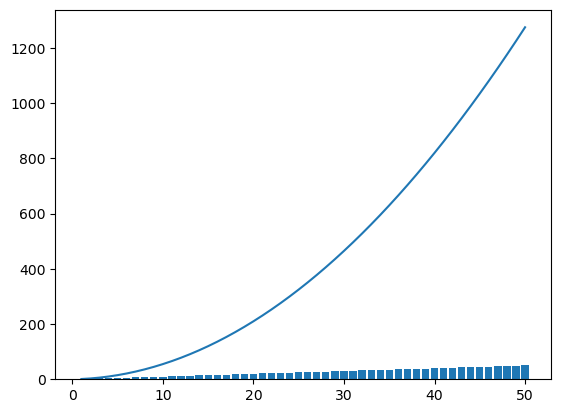

In [176]:
import matplotlib.pyplot as plt
import numpy as np
 
array_sizes = range(1, 51)
cumulative_costs = np.cumsum(array_sizes)
 
plt.bar(array_sizes, array_sizes, label="insert/append cost")
plt.plot(array_sizes, cumulative_costs, label="cumulative cost")

As a general rule, you should avoid updating NumPy arrays one element at a time, since you are not taking advantage of NumPy's efficient array processing. But even more important, do not grow NumPy arrays one element at a time. Even that phrasing is misleading; you are not growing an array, but repeatedly destroying and recreating slightly bigger arrays at massive cost. Even if you can not populate the array with fast processing, at least figure out how big it will be and create it once. Manually updating one element at a time in an array is far faster than repeatedly recreating it one larger.

## 7.7 Lesson: Finding NumPy Functions
NumPy has a lot of functionality. We have given many examples of many different functions in the last couple weeks, but there are many many more functions available in NumPy. We will conclude our NumPy coverage with tips on where to look for NumPy functions, and details to check before using them.

### Where to Look for More NumPy Functionality
Where should you look for a NumPy function if you don't know what it is called?

- Google or your favorite search engine is generally a fine place to start. Just search for "NumPy THING YOU WANT TO DO", and select a link from numpy.org. Use "numpy.org" in your search to bias it more.
- If you know a similar NumPy function, the index of related functions (on the left as of April 2024), is a decent place to skim
- NumPy's documentation is easy enough to navigate
- Last but not least, you can ask your favorite AI chat bot, but please look up the real documentation on numpy.org before you use any function that you discover that way. Not all functions mentioned by large language models exist, and they sometimes miss important nuances.
### Details to Check When Using a New NumPy Function
Whenever you use a new NumPy function, check the documentation to make sure you know what it is doing. As we saw with the functions to insert, append, and delete, sometimes the names are a little misleading, and there are important details you will see in the documentation.

Some specific details to check:

1. Does this function make a view or a completely new array? Does that vary? If you are seeing the same data presented differently, a view is preferred. If you are calculating, a new array is usually unavoidable. But sometimes, there are a few similar functions that vary in this behavior, like we saw with flattening arrays.
2. If the function is calculating, is it a universal function? If not, how does it generalize with different numbers of dimensions? This is more likely to come up for linear algebra functions which we think of as operating on 2-dimensional matrices, but the NumPy versions may accept more dimensions.

It's good to know the answers to these questions for any NumPy function that you use. Later on, you may be using other libraries such as TensorFlow or PyTorch which are inspired by or based on NumPy, and you'll want to ask these questions then too.

In [177]:
def f12(vs):
    return [v for (i, v) in enumerate(vs) if i >= 5]

def g12(n):
    for i in range(n):
        yield i ** 2

print(f12(g12(10)))

[25, 36, 49, 64, 81]
